In [ ]:
!pip install opencv-python

In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import shuffle
import datetime
import os
from collections import deque
import copy
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import np_utils

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras 
from keras import backend as K
tf.random.set_seed(30)

In [3]:
proj_data_dir = "C:/Users/scpow/Documents/LEARNING/IITB - MSC in ML & AI/05 - Deep Learning/06-Case Study - Gesture Recognition/Project_data/"
img = cv2.imread(proj_data_dir+'train/WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_38_17_Pro_00029.png')
img.shape

(360, 360, 3)

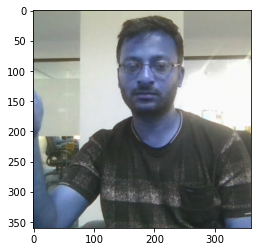

In [4]:
plt.imshow(img/255)

In [18]:
# Initializing files

proj_data_dir = "C:/Users/scpow/Documents/LEARNING/IITB - MSC in ML & AI/05 - Deep Learning/06-Case Study - Gesture Recognition/Project_data/"

train_doc = np.random.permutation(open(proj_data_dir+'train.csv').readlines())
val_doc = np.random.permutation(open(proj_data_dir+'val.csv').readlines())

train_path = os.path.join(proj_data_dir,'train')
val_path = os.path.join(proj_data_dir,'val')

seq = 15
class_label = 5

In [19]:
train_path

'C:/Users/scpow/Documents/LEARNING/IITB - MSC in ML & AI/05 - Deep Learning/06-Case Study - Gesture Recognition/Project_data/train'

In [20]:
# Custom Generator function

def generator(source_path, folder_list, batch_size):
    print( '\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(10,25)] #create a list of image numbers you want to use for a particular video
    while True:
        
        t = np.random.permutation(folder_list)
        num_batches =  int(len(folder_list)/batch_size) # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            x = len(img_idx)
            y = 100
            z = 100
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = cv2.resize(image, (100, 100))
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    b=image[:,:,0]
                    g=image[:,:,1]
                    r=image[:,:,2]
                    
                    batch_data[folder,idx,:,:,0] = b/ 255.0  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = g/ 255.0  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = r/ 255.0  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if len(t)%batch_size != 0:
            
            x = len(img_idx)
            y = 100
            z = 100
            
            #batch_size = len(t)%batch_size
            
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = cv2.resize(image, (100, 100))
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    b=image[:,:,0]
                    g=image[:,:,1]
                    r=image[:,:,2]
                    
                    batch_data[folder,idx,:,:,0] = b/ 255.0  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = g/ 255.0  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = r/ 255.0  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [21]:
'''
gen1 = generator(train_path, train_doc, batch_size)
x,y = next(gen1)

#folders, images, 100, 100, rgb_channel
print(x.shape)
plt.imshow(x[0][0])
print(y[0])
'''

'\ngen1 = generator(train_path, train_doc, batch_size)\nx,y = next(gen1)\n\n#folders, images, 100, 100, rgb_channel\nprint(x.shape)\nplt.imshow(x[0][0])\nprint(y[0])\n'

In [22]:
#Initializing parameters

curr_dt_time = datetime.datetime.now()
print('# curr_dt_time = ', curr_dt_time)
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100 # choose the number of epochs
print ('# epochs =', num_epochs)


# curr_dt_time =  2022-07-13 00:40:53.609902
# training sequences = 663
# validation sequences = 100
# epochs = 100


In [23]:
#train-val generator

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [24]:
#code to create Folder to save model at every epoch

model_name = 'model_init' + '_' + str(curr_dt_time).split('.')[0].replace(' ','_').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [25]:
#Some more parameters

batch_size = 150 
#experiment with the batch size
#300 is too high; kernel reset
#150 working well for Conv2d+LSTM model

steps_per_epoch = 0

validation_steps = 0

num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(f'steps_per_epoch: {steps_per_epoch}')
print(f'validation_steps: {validation_steps}')

steps_per_epoch: 23
validation_steps: 4


# Model

In [26]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras import regularizers
from keras import optimizers

In [31]:
#custom function to plot accuracy and loss of train and validation data set

def accuracy_loss_plt(model_history):
    acc = model_history.history['categorical_accuracy']
    val_acc = model_history.history['val_categorical_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    
    best_val_accuracy=  max(model_history.history['val_categorical_accuracy'])
    best_val_loss = min(model_history.history['val_loss'])
    
    #epochs_range = range(epochs)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot( acc, label='Training Accuracy')
    plt.plot( val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.subplot(1, 2, 2)
    plt.plot( loss, label='Training Loss')
    plt.plot( val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()   
    
    print(f'best_val_accuracy: {best_val_accuracy}')
    print(f'best_val_loss: {best_val_loss}')

## Conv2D + LSTM Model

In [11]:
#write your model here

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),input_shape = (15, 100, 100, 3)))
model.add(TimeDistributed(MaxPooling2D((4, 4)))) 

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
model.add(TimeDistributed(Flatten()))
                                     
model.add(LSTM(32))
                                      
model.add(Dense(class_label, activation = 'softmax'))



In [12]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 25, 25, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 6, 6, 32)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 6, 6, 64)      18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 3, 3, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 3, 3, 64)      3

In [18]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
5/5 [==============================] - 116s 26s/step - loss: 1.6037 - categorical_accuracy: 0.1885 - val_loss: 1.5911 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2022-07-11_234103\model-00001-1.60372-0.18854-1.59110-0.23000.h5
Epoch 2/100
5/5 [==============================] - 100s 23s/step - loss: 1.6004 - categorical_accuracy: 0.1916 - val_loss: 1.5860 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2022-07-11_234103\model-00002-1.60039-0.19155-1.58597-0.23000.h5
Epoch 3/100
5/5 [==============================] - 100s 22s/step - loss: 1.5832 - categorical_accuracy: 0.2142 - val_loss: 1.5713 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2022-07-11_234103\model-00003-1.58316-0.21418-1.57126-0.23000.h5
Epoch 4/100
5/5 [==============================] - 85s 19s/step - loss: 1.5704 - categorical_accuracy: 0.2323 - val_loss: 1.5480 - val_categorical_accuracy: 0.4200

Epoch 00004: saving mo

In [19]:
model_history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

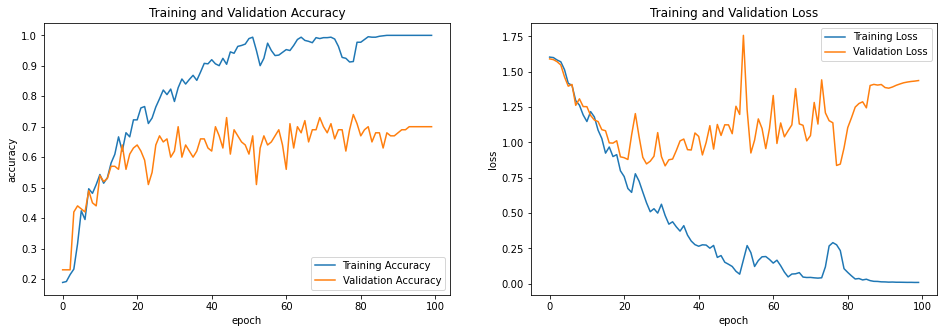

In [20]:
 accuracy_loss_plt(model_history)

## Conv2D + LSTM model : Adding Dropout Layer

In [21]:
# Overfitting on training data -> model not doing good on validation data over the epochs
# Adding Dropout layers to the model

In [22]:
#### Adding dropout layer to the model

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),input_shape = (15, 100, 100, 3)))
model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D((4, 4))))
model.add(TimeDistributed(Dropout(0.25)))
    
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))
    
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))
                                      
model.add(TimeDistributed(Flatten()))
                                      
model.add(LSTM(32))
                                      
model.add(Dense(class_label, activation = 'softmax'))


In [24]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 25, 25, 32)    4640      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 6, 6, 32)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 6, 6, 32)      0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 6, 6, 64)     

In [25]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
5/5 [==============================] - 92s 21s/step - loss: 1.6241 - categorical_accuracy: 0.1961 - val_loss: 1.6074 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2022-07-11_234103\model-00001-1.62412-0.19608-1.60740-0.18000.h5
Epoch 2/100
5/5 [==============================] - 85s 21s/step - loss: 1.6046 - categorical_accuracy: 0.1961 - val_loss: 1.6021 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2022-07-11_234103\model-00002-1.60459-0.19608-1.60212-0.21000.h5
Epoch 3/100
5/5 [==============================] - 82s 20s/step - loss: 1.5944 - categorical_accuracy: 0.2805 - val_loss: 1.5990 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2022-07-11_234103\model-00003-1.59438-0.28054-1.59896-0.24000.h5
Epoch 4/100
5/5 [==============================] - 82s 20s/step - loss: 1.5835 - categorical_accuracy: 0.2624 - val_loss: 1.5943 - val_categorical_accuracy: 0.2700

Epoch 00004: saving model

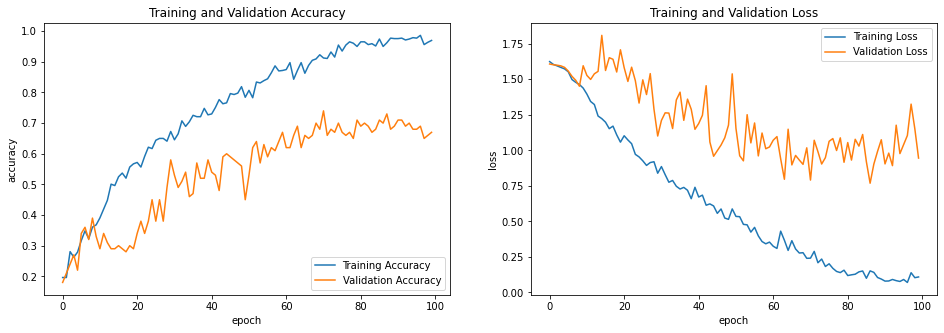

best_val_accuracy: 0.7400000095367432
best_val_loss: 0.7685701251029968


In [36]:
accuracy_loss_plt(model_history)

## Conv3D Model

In [34]:
model = Sequential()

model.add(Conv3D(16, kernel_size=3, input_shape=(15, 100, 100, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(class_label, activation='softmax'))


In [35]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 13, 98, 98, 16)    1312      
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 98, 98, 16)    64        
_________________________________________________________________
activation_9 (Activation)    (None, 13, 98, 98, 16)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 11, 96, 96, 32)    13856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 11, 96, 96, 32)    128       
_________________________________________________________________
activation_10 (Activation)   (None, 11, 96, 96, 32)    0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 5, 48, 48, 32)    

#### Updating the batch size to 30 as 150 too high for CNN 3D model

In [36]:
batch_size = 30 
#experiment with the batch size
#300 is too high; 
#failing with 150 

steps_per_epoch = 0

validation_steps = 0

num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(f'steps_per_epoch: {steps_per_epoch}')
print(f'validation_steps: {validation_steps}')

steps_per_epoch: 23
validation_steps: 4


In [38]:
#temporarily changing epoch size to 10

model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
23/23 [==============================] - 569s 25s/step - loss: 9.3066 - categorical_accuracy: 0.7934 - val_loss: 10.5437 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-07-13_004053\model-00001-9.30658-0.79336-10.54371-0.21000.h5
Epoch 2/10
23/23 [==============================] - 544s 24s/step - loss: 7.5269 - categorical_accuracy: 0.8250 - val_loss: 8.5609 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2022-07-13_004053\model-00002-7.52689-0.82504-8.56086-0.15000.h5
Epoch 3/10
23/23 [==============================] - 546s 24s/step - loss: 3.9016 - categorical_accuracy: 0.8944 - val_loss: 8.0601 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2022-07-13_004053\model-00003-3.90161-0.89442-8.06011-0.21000.h5
Epoch 4/10
23/23 [==============================] - 489s 21s/step - loss: 1.3669 - categorical_accuracy: 0.9593 - val_loss: 16.4997 - val_categorical_accuracy: 0.2800

Epoch 00004: s

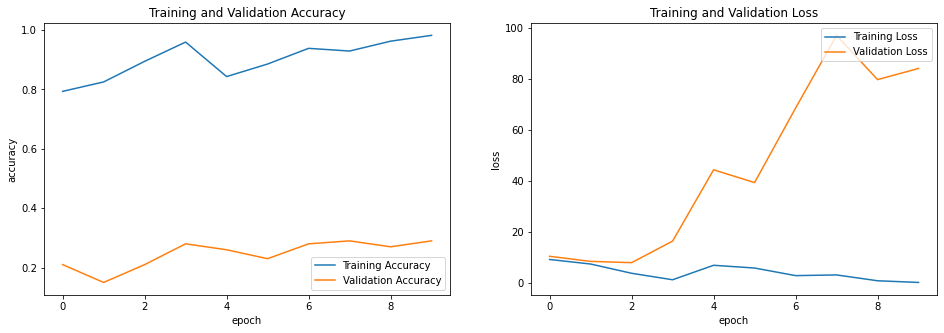

best_val_accuracy: 0.28999999165534973
best_val_loss: 8.060107231140137


In [39]:
accuracy_loss_plt(model_history)

#### A very simple cnn3d model implemeted and ran for only 10 epochs just for experimenting. Hyper-parameter tuning and more layers to be added. Still in progress